# Práctica 2

In [2]:
# Importación de módulos necesarios
using DataFrames
using CSV
using Statistics
using Random
using HypothesisTests
using StatsBase
using Plots
using MLJ, MLJBase, MLJModels, MLJModelInterface
using CategoricalArrays
using LinearAlgebra
using Printf

using MultivariateStats
using TSne
using ManifoldLearning

# Configuración de semilla para reproducibilidad
const SEED = 104
Random.seed!(SEED)

println("Paquetes cargados correctamente")

Paquetes cargados correctamente


## PARTE 1: PREPARACIÓN DE LOS DATOS

### 1.1 Carga y unificación de datos

In [3]:
# Función recursiva para encontrar todos los CSV
function all_csv_files(dir::String)
    archivos = String[]
    for entry in readdir(dir; join=true)
        if isdir(entry) # si es un directorio, llamar recursivamente
            append!(archivos, all_csv_files(entry)) 
        elseif endswith(entry, ".csv") # si es un archivo CSV
            push!(archivos, entry)
        end
    end
    return archivos
end

function import_dataset()
    base_path = joinpath(pwd(), "Datos_Práctica_Evaluación")

    # Obtener todos los archivos CSV recursivamente
    rutas = all_csv_files(base_path)
    println("Archivos CSV encontrados: ", length(rutas))
    
    if isempty(rutas)
        error("No se encontraron archivos CSV en la estructura de carpetas.")
    end
    
    # Leer y combinar todos los CSV
    dfs = DataFrame[]
    for (i, ruta) in enumerate(rutas)
        println("  [$i/$(length(rutas))] Leyendo: ", basename(ruta))
        df_temp = CSV.read(ruta, DataFrame)
        push!(dfs, df_temp)
    end

    # Concatenar todos los DataFrames
    df_unificado = vcat(dfs...)
    println("Dimensiones del DataFrame unificado: ", size(df_unificado))
    return df_unificado
end

println("\n" * "-"^80)
println("CARGA Y UNIFICACIÓN DE DATOS")
println("-"^80)

# Importar el dataset unificado
df = import_dataset()



--------------------------------------------------------------------------------
CARGA Y UNIFICACIÓN DE DATOS
--------------------------------------------------------------------------------
Archivos CSV encontrados: 30
  [1/30] Leyendo: Sujeto_01.csv
  [2/30] Leyendo: Sujeto_05.csv
  [3/30] Leyendo: Sujeto_07.csv
  [4/30] Leyendo: Sujeto_11.csv
  [5/30] Leyendo: Sujeto_03.csv
  [6/30] Leyendo: Sujeto_09.csv
  [7/30] Leyendo: Sujeto_23.csv
  [8/30] Leyendo: Sujeto_25.csv
  [9/30] Leyendo: Sujeto_15.csv
  [10/30] Leyendo: Sujeto_17.csv
  [11/30] Leyendo: Sujeto_21.csv
  [12/30] Leyendo: Sujeto_13.csv
  [13/30] Leyendo: Sujeto_19.csv
  [14/30] Leyendo: Sujeto_27.csv
  [15/30] Leyendo: Sujeto_29.csv
  [16/30] Leyendo: Sujeto_02.csv
  [17/30] Leyendo: Sujeto_04.csv
  [18/30] Leyendo: Sujeto_06.csv
  [19/30] Leyendo: Sujeto_08.csv
  [20/30] Leyendo: Sujeto_10.csv
  [21/30] Leyendo: Sujeto_12.csv
  [22/30] Leyendo: Sujeto_14.csv
  [23/30] Leyendo: Sujeto_16.csv
  [24/30] Leyendo: Sujeto_18.

Row,subject,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,tBodyAcc-max()-Y,tBodyAcc-max()-Z,tBodyAcc-min()-X,tBodyAcc-min()-Y,tBodyAcc-min()-Z,tBodyAcc-sma(),tBodyAcc-energy()-X,tBodyAcc-energy()-Y,tBodyAcc-energy()-Z,tBodyAcc-iqr()-X,tBodyAcc-iqr()-Y,tBodyAcc-iqr()-Z,tBodyAcc-entropy()-X,tBodyAcc-entropy()-Y,tBodyAcc-entropy()-Z,"tBodyAcc-arCoeff()-X,1","tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-X,3","tBodyAcc-arCoeff()-X,4","tBodyAcc-arCoeff()-Y,1","tBodyAcc-arCoeff()-Y,2","tBodyAcc-arCoeff()-Y,3","tBodyAcc-arCoeff()-Y,4","tBodyAcc-arCoeff()-Z,1","tBodyAcc-arCoeff()-Z,2","tBodyAcc-arCoeff()-Z,3","tBodyAcc-arCoeff()-Z,4","tBodyAcc-correlation()-X,Y","tBodyAcc-correlation()-X,Z","tBodyAcc-correlation()-Y,Z",tGravityAcc-mean()-X,tGravityAcc-mean()-Y,tGravityAcc-mean()-Z,tGravityAcc-std()-X,tGravityAcc-std()-Y,tGravityAcc-std()-Z,tGravityAcc-mad()-X,tGravityAcc-mad()-Y,tGravityAcc-mad()-Z,tGravityAcc-max()-X,tGravityAcc-max()-Y,tGravityAcc-max()-Z,tGravityAcc-min()-X,tGravityAcc-min()-Y,tGravityAcc-min()-Z,tGravityAcc-sma(),tGravityAcc-energy()-X,tGravityAcc-energy()-Y,tGravityAcc-energy()-Z,tGravityAcc-iqr()-X,tGravityAcc-iqr()-Y,tGravityAcc-iqr()-Z,tGravityAcc-entropy()-X,tGravityAcc-entropy()-Y,tGravityAcc-entropy()-Z,"tGravityAcc-arCoeff()-X,1","tGravityAcc-arCoeff()-X,2","tGravityAcc-arCoeff()-X,3","tGravityAcc-arCoeff()-X,4","tGravityAcc-arCoeff()-Y,1","tGravityAcc-arCoeff()-Y,2","tGravityAcc-arCoeff()-Y,3","tGravityAcc-arCoeff()-Y,4","tGravityAcc-arCoeff()-Z,1","tGravityAcc-arCoeff()-Z,2","tGravityAcc-arCoeff()-Z,3","tGravityAcc-arCoeff()-Z,4","tGravityAcc-correlation()-X,Y","tGravityAcc-correlation()-X,Z","tGravityAcc-correlation()-Y,Z",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,tBodyAccJerk-mean()-Z,tBodyAccJerk-std()-X,tBodyAccJerk-std()-Y,tBodyAccJerk-std()-Z,tBodyAccJerk-mad()-X,tBodyAccJerk-mad()-Y,tBodyAccJerk-mad()-Z,tBodyAccJerk-max()-X,tBodyAccJerk-max()-Y,tBodyAccJerk-max()-Z,tBodyAccJerk-min()-X,tBodyAccJerk-min()-Y,tBodyAccJerk-min()-Z,tBodyAccJerk-sma(),tBodyAccJerk-energy()-X,tBodyAccJerk-energy()-Y,tBodyAccJerk-energy()-Z,⋯
,Int64,Float64,Float64,Float64,Float64?,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64?,Float64,Float64,Float64?,Float64?,Float64?,Float64?,Float64?,Float64,Float64,Float64,Float64,Float64?,Float64?,Float64?,Float64,⋯
1,1,0.288585,-0.0202942,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,-0.567378,-0.744413,0.852947,0.685845,0.814263,-0.965523,-0.999945,-0.999863,-0.994612,-0.994231,-0.987614,-0.94322,-0.407747,-0.679338,missing,0.929294,-0.853011,0.35991,-0.0585264,0.256892,-0.224848,0.264106,-0.0952456,0.278851,-0.465085,0.491936,-0.190884,0.376314,0.435129,0.66079,0.963396,-0.14084,0.115375,-0.98525,-0.981708,-0.877625,-0.985001,-0.984416,-0.894677,0.892055,-0.161265,0.12466,0.977436,-0.123213,0.0564827,-0.375426,0.899469,-0.970905,-0.97551,-0.984325,-0.988849,-0.917743,-1.0,-1.0,0.113806,-0.590425,0.591146,missing,0.592469,-0.745449,0.720862,-0.712372,0.7113,-0.995112,0.995675,-0.995668,0.991653,0.570222,0.439027,0.986913,0.0779963,0.0050008,-0.0678308,-0.993519,-0.98836,-0.993575,-0.994488,-0.986207,-0.992818,-0.98518,-0.991994,-0.993119,0.989835,0.991957,0.990519,-0.993522,-0.999935,-0.99982,-0.999878,⋯
2,1,0.274262,-0.012

In [4]:
println("\n" * "-"^80)
println("DESCRIPCIÓN DEL DATASET")
println("-"^80)

# Número de variables (columnas)
num_variables = ncol(df)
println("• Número de variables: ", num_variables)

# Número de instancias (filas)
num_instancias = nrow(df)
println("• Número de instancias: ", num_instancias)

# Número de individuos únicos (columna 'subject')
num_individuos = length(unique(df.subject))
println("• Número de individuos: ", num_individuos)

# Columna de salida: la última columna
num_clases_salida = length(unique(df.Activity))
println("• Número de clases de salida: ", num_clases_salida)

clases = unique(df.Activity)
println("• Clases de salida (activity): ", clases)



--------------------------------------------------------------------------------
DESCRIPCIÓN DEL DATASET
--------------------------------------------------------------------------------
• Número de variables: 563
• Número de instancias: 10299
• Número de individuos: 30
• Número de clases de salida: 6
• Clases de salida (activity): String31["STANDING", "SITTING", "LAYING", "WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS"]


### 1.2 Análisis de valores ausentes

In [5]:
function missing_values_summary(df::DataFrame)   
    # Lista de columnas con missing
    columnas_con_missing = String[]
    missing_counts = Dict{String, Int}()
    
    println("\nColumnas con valores ausentes:")
    for col in names(df)
        num_missing = count(ismissing, df[!, col])
        if num_missing > 0
            push!(columnas_con_missing, col)
            missing_counts[col] = num_missing
            pct_missing = num_missing / nrow(df) * 100
            println("  • $(col): $(num_missing) valores ($(round(pct_missing, digits=2))%)")
        end
    end
    
    if isempty(columnas_con_missing)
        println("    No hay columnas con valores ausentes.")
    else
        println("\n  Total de columnas con valores ausentes: ", length(columnas_con_missing))
    end
    
    # Porcentaje de valores ausentes en todo el dataset
    total_missing = count(ismissing, Iterators.flatten(eachcol(df)))
    total_values = nrow(df) * ncol(df)
    pct_total_missing = total_missing / total_values * 100
    println("\n  Porcentaje total de valores ausentes: $(round(pct_total_missing, digits=4))%")
    
    return columnas_con_missing, missing_counts
end

println("\n" * "-"^80)
println("ANÁLISIS DE VALORES AUSENTES")
println("-"^80)
columnas_missing, missing_counts = missing_values_summary(df);


--------------------------------------------------------------------------------
ANÁLISIS DE VALORES AUSENTES
--------------------------------------------------------------------------------

Columnas con valores ausentes:
  • tBodyAcc-std()-X: 2 valores (0.02%)
  • tBodyAcc-std()-Z: 2 valores (0.02%)
  • tBodyAcc-mad()-X: 2 valores (0.02%)
  • tBodyAcc-mad()-Y: 3 valores (0.03%)
  • tBodyAcc-mad()-Z: 3 valores (0.03%)
  • tBodyAcc-max()-X: 2 valores (0.02%)
  • tBodyAcc-max()-Z: 1 valores (0.01%)
  • tBodyAcc-sma(): 1 valores (0.01%)
  • tBodyAcc-iqr()-X: 3 valores (0.03%)
  • tBodyAcc-iqr()-Y: 1 valores (0.01%)
  • tBodyAcc-entropy()-Z: 1029 valores (9.99%)
  • tBodyAcc-arCoeff()-Z,2: 1029 valores (9.99%)
  • tBodyAcc-correlation()-X,Y: 1029 valores (9.99%)
  • tGravityAcc-std()-Y: 1029 valores (9.99%)
  • tGravityAcc-std()-Z: 1029 valores (9.99%)
  • tGravityAcc-mad()-Z: 1029 valores (9.99%)
  • tGravityAcc-max()-X: 1029 valores (9.99%)
  • tGravityAcc-arCoeff()-X,3: 1029 valores (

### 1.3  Tratamiento y transformación de datos

Mediana por sujeto (subject-wise).
Los datos son MCAR y cada sujeto tiene características únicas.

In [6]:
function subject_wise_mean_imputation(df::DataFrame)
    df_imputed = deepcopy(df)
    subject_col = :subject
    
    # Obtener columnas numéricas con missing
    num_cols = String[]
    for col in names(df)
        if col != string(subject_col) && col != "Activity" && any(ismissing, df[!, col])
            push!(num_cols, col)
        end
    end
    
    println("  Columnas numéricas a imputar: ", length(num_cols))
    
    # Contadores para estadísticas
    total_imputed = 0
    
    for subj in unique(df[!, subject_col])
        idx = findall(==(subj), df[!, subject_col])
        subdf = df[idx, :]
        
        for col in num_cols
            # Contar valores missing en esta columna para este sujeto
            missing_mask = ismissing.(subdf[!, col])
            n_missing = sum(missing_mask)
            
            if n_missing == 0
                continue
            end
            
            # Si todos los valores del sujeto son missing, usar la mediana global
            if all(missing_mask)
                # Media global (de todos los sujetos que tienen valores)
                global_median = median(skipmissing(df[!, col]))
                df_imputed[idx, col] .= global_median
                total_imputed += n_missing
            else
                # Calcular la mediana del sujeto
                subject_median = median(skipmissing(subdf[!, col]))
                # Reemplazar missing por la mediana del sujeto
                df_imputed[idx, col] = coalesce.(df_imputed[idx, col], subject_median)
                total_imputed += n_missing
            end
        end
    end
    
    for col in names(df_imputed)
        if col != string(subject_col) && col != "Activity"
            df_imputed[!, col] = Float64.(df_imputed[!, col])
        end
    end

    println("  Valores imputados: ", total_imputed)
    return df_imputed
end

println("\n" * "-"^80)
println("TRATAMIENTO Y TRANSFORMACIÓN DE DATOS")
println("-"^80)

df_imputed = subject_wise_mean_imputation(df)

# Comprobar que no quedan valores ausentes
println("\n  Verificación post-imputación:")
remaining_missing = count(ismissing, Iterators.flatten(eachcol(df_imputed)))
println("  Valores ausentes restantes: ", remaining_missing)
@assert remaining_missing == 0 "Existen valores ausentes"


--------------------------------------------------------------------------------
TRATAMIENTO Y TRANSFORMACIÓN DE DATOS
--------------------------------------------------------------------------------
  Columnas numéricas a imputar: 175
  Valores imputados: 57892

  Verificación post-imputación:
  Valores ausentes restantes: 0


### Separación de datos: X (features), y (target), subject_id

Separa el dataset en:
- X: Matriz de características (Float64)
- y: Vector categórico de etiquetas (CategoricalArray)
- subject_id: Vector de IDs de sujetos


NO se usa one-hot encoding. MLJ trabaja mejor con CategoricalArray

In [7]:
function separate_data(df::DataFrame)
    
    # Columnas a excluir (Subject y Target)
    cols_to_exclude = [:subject, :Activity]    

    # Se mantiene X Como DataFrame
    X = DataFrames.select(df, Not(cols_to_exclude))
    
    # Target (como Multiclass)
    y = coerce(df.Activity, Multiclass)    

    return X, y, df.subject
end

println("\n" * "-"^80)
println("SEPARACIÓN DE DATOS")
println("-"^80)

X_full, y_full, subject_id_full = separate_data(df_imputed)
println("\nDatos separados:")
println(" • X (features): $(size(X_full)) - Tipo: $(typeof(X_full))")
println(" • y (target): $(size(y_full)) - Tipo: $(typeof(y_full))")
println(" • subject_id: $(size(subject_id_full))")



--------------------------------------------------------------------------------
SEPARACIÓN DE DATOS
--------------------------------------------------------------------------------

Datos separados:
 • X (features): (10299, 561) - Tipo: DataFrame
 • y (target): (10299,) - Tipo: CategoricalVector{String31, UInt32, String31, CategoricalValue{String31, UInt32}, Union{}}
 • subject_id: (10299,)


### 1.4 Partición Holdout (subject-wise)

Realiza la partición holdout asegurando que todos los datos de un sujeto están en el mismo conjunto (train o test).

In [8]:
function holdout_split_subject_wise(X, y, subject_id::AbstractArray; test_ratio::Real=0.1)

    # Asegurar reproducibilidad
    Random.seed!(SEED) 
    
    unique_subjects = unique(subject_id)
    num_subjects = length(unique_subjects)
    
    # Seleccionar el 10% de sujetos para test
    num_test_subjects = round(Int, num_subjects * test_ratio)
    test_subjects = shuffle(unique_subjects)[1:num_test_subjects]
    println("  Individuos seleccionados para TEST (holdout $(round(test_ratio*100))%): ", sort(test_subjects))

    # División de instancias
    is_test = [s in test_subjects for s in subject_id]
    is_train = .!is_test
    
    X_train = X[is_train, :]
    y_train = y[is_train]
    subject_train = subject_id[is_train]
    
    X_test = X[is_test, :]
    y_test = y[is_test]
    subject_test = subject_id[is_test]

    println("\n  Partición Holdout completada:")
    println("  • TRAIN: $(size(X_train, 1)) instancias ($(length(unique(subject_train))) sujetos)")
    println("  • TEST: $(size(X_test, 1)) instancias ($(length(unique(subject_test))) sujetos)")

    # Verificar distribución de clases
    println("\n  Distribución de clases en TRAIN:")
    for (clase, count) in sort(collect(countmap(y_train)))
        pct = count / length(y_train) * 100
        println("    • $clase: $count ($(round(pct, digits=1))%)")
    end
    
    println("\n  Distribución de clases en TEST:")
    for (clase, count) in sort(collect(countmap(y_test)))
        pct = count / length(y_test) * 100
        println("    • $clase: $count ($(round(pct, digits=1))%)")
    end

    return X_train, y_train, subject_train, X_test, y_test, subject_test
end

println("\n" * "-"^80)
println("PARTICIÓN HOLDOUT (10% TEST)")
println("-"^80)
X_train, y_train, subject_train, X_test, y_test, subject_test = holdout_split_subject_wise(X_full, y_full, subject_id_full);




--------------------------------------------------------------------------------
PARTICIÓN HOLDOUT (10% TEST)
--------------------------------------------------------------------------------
  Individuos seleccionados para TEST (holdout 10.0%): [18, 22, 25]

  Partición Holdout completada:
  • TRAIN: 9205 instancias (27 sujetos)
  • TEST: 1094 instancias (3 sujetos)

  Distribución de clases en TRAIN:
    • LAYING: 1734 (18.8%)
    • SITTING: 1593 (17.3%)
    • STANDING: 1696 (18.4%)
    • WALKING: 1546 (16.8%)
    • WALKING_DOWNSTAIRS: 1257 (13.7%)
    • WALKING_UPSTAIRS: 1379 (15.0%)

  Distribución de clases en TEST:
    • LAYING: 210 (19.2%)
    • SITTING: 184 (16.8%)
    • STANDING: 210 (19.2%)
    • WALKING: 176 (16.1%)
    • WALKING_DOWNSTAIRS: 149 (13.6%)
    • WALKING_UPSTAIRS: 165 (15.1%)


### 1.5  Validación cruzada individual-wise 

Crea k particiones para validación cruzada asegurando que todos los datos de un sujeto están en el mismo fold.


In [10]:
function individualwise_cv_splits(subject_id::AbstractVector; k=5)
    Random.seed!(SEED)
    
    subjects = unique(subject_id)
    n = length(subjects)
    shuffled = shuffle(subjects)

    # Dividir sujetos en k folds equilibrados
    folds = [shuffled[floor(Int, (i-1)*n/k)+1 : floor(Int, i*n/k)] for i in 1:k]

    splits = Vector{NamedTuple{(:train,:test),Tuple{Vector{Int},Vector{Int}}}}(undef, k)
    
    println("\nFOLD | Train (muestras) | Val (muestras) | Train sujetos | Val sujetos")
    println("----------------------------------------------------------------------")

    for i in 1:k
        val_subjects = folds[i]
        train_subjects = vcat(folds[1:i-1]..., folds[i+1:end]...)
        
        train_idx = findall(s -> s in train_subjects, subject_id)
        val_idx   = findall(s -> s in val_subjects, subject_id)
        
        splits[i] = (train=train_idx, test=val_idx)
        
        @printf("  %d  |       %4d       |      %4d      |       %2d      |     %2d\n",
                i, length(train_idx), length(val_idx), length(train_subjects), length(val_subjects))
    end

    return splits
end

cv_splits = individualwise_cv_splits(subject_train; k=5);



FOLD | Train (muestras) | Val (muestras) | Train sujetos | Val sujetos
----------------------------------------------------------------------
  1  |       7378       |      1827      |       22      |      5
  2  |       7565       |      1640      |       22      |      5
  3  |       7103       |      2102      |       21      |      6
  4  |       7503       |      1702      |       22      |      5
  5  |       7271       |      1934      |       21      |      6


### 1.6 Normalización

In [11]:
println("\n" * "-"^80)
println("NORMALIZACIÓN")
println("-"^80)

mutable struct MinMaxNormalizer <: MLJModelInterface.Unsupervised end

function MLJModelInterface.fit(normalizer::MinMaxNormalizer, verbosity::Int, X)
    X_matrix = Float64.(MLJBase.matrix(X))
    
    # Calcular min y max por columna
    feature_min = vec(minimum(X_matrix, dims=1))
    feature_max = vec(maximum(X_matrix, dims=1))
    
    # Guardar los nombres de las columnas
    feature_names = collect(Tables.columnnames(X))
    
    fitresult = (feature_min=feature_min, feature_max=feature_max, feature_names=feature_names)
    cache = nothing
    report = (feature_ranges = feature_max .- feature_min,)
    
    return fitresult, cache, report
end

function MLJModelInterface.transform(normalizer::MinMaxNormalizer, fitresult, X)
    X_matrix = Float64.(MLJBase.matrix(X))
    feature_min = fitresult.feature_min
    feature_max = fitresult.feature_max
    feature_names = fitresult.feature_names
    
    ranges = feature_max .- feature_min
    
    # Evitar división por cero en columnas con rango 0
    zero_range = ranges .≈ 0.0
    ranges[zero_range] .= 1.0
    
    X_normalized = (X_matrix .- feature_min') ./ ranges'
    X_normalized[:, zero_range] .= 0.0
    
    # Devolver usando MLJBase.table con nombres
    return MLJBase.table(X_normalized, names=feature_names)
end

# Registrar el transformador en MLJ
MLJModelInterface.input_scitype(::Type{<:MinMaxNormalizer}) = Table(Continuous)
MLJModelInterface.output_scitype(::Type{<:MinMaxNormalizer}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:MinMaxNormalizer}) = Nothing

println("\nMinMaxNormalizer registrado en MLJ: ", MinMaxNormalizer())


--------------------------------------------------------------------------------
NORMALIZACIÓN
--------------------------------------------------------------------------------

MinMaxNormalizer registrado en MLJ: MinMaxNormalizer()


## PARTE 2: Modelos básicos y selección de atributos

### 2.1 Filtrado de características

- Sin reducción
- Filtrado ANOVA
- Filtrado de Pearson
- Filtrado de Spearman
- Filtrado de Kendall Tau
- Filtrado por Mutual Information
- Filtrado RFE (con Logistic Regression, eliminando el 50 % de las variables 
en cada iteración)


Filtrado ANOVA

In [12]:
mutable struct ANOVAFilter <: MLJModelInterface.Supervised
    k::Int
end
ANOVAFilter(; k::Int=50) = ANOVAFilter(k)

function MLJModelInterface.fit(model::ANOVAFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Int.(levelcode.(y)) : Int.(y)
    
    n_features = size(Xmat, 2)
    fstats = zeros(Float64, n_features)
    
    for j in 1:n_features
        feature = Xmat[:, j]
        classes = unique(y_numeric)
        groups = [feature[y_numeric .== c] for c in classes]
        groups = filter(g -> length(g) > 0, groups)
        
        if length(groups) >= 2
            try
                test = OneWayANOVATest(groups...)
                MSt = test.SStᵢ / test.DFt
                MSe = test.SSeᵢ / test.DFe
                fstats[j] = MSe > 0 ? MSt / MSe : 0.0
            catch
                fstats[j] = 0.0
            end
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(fstats, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (fstats=fstats, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::ANOVAFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:ANOVAFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:ANOVAFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:ANOVAFilter}) = Table(Continuous)

println("\nANOVAFilter registrado en MLJ: ", ANOVAFilter())


ANOVAFilter registrado en MLJ: ANOVAFilter(k = 50)


Filtrado de Pearson

In [13]:
mutable struct PearsonCorrelationFilter <: MLJModelInterface.Supervised
    k::Int
end

PearsonCorrelationFilter(; k::Int=50) = PearsonCorrelationFilter(k)

function MLJModelInterface.fit(model::PearsonCorrelationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Float64.(levelcode.(y)) : Float64.(y)    
    
    n_features = size(Xmat, 2)
    scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            scores[j] = abs(cor(Xmat[:, j], y_numeric))
        catch
            scores[j] = 0.0
        end
    end

    k_actual = min(model.k, n_features)
    idxs = sortperm(scores, rev=true)[1:k_actual]
    
    # Recuperamos nombres
    feature_names = try names(X) catch; string.(1:n_features) end
    selected_names = feature_names[idxs]

    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (scores=scores, selected_indices=idxs, selected_features=selected_names)

    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::PearsonCorrelationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    
    # Devolvemos una tabla (DataFrame) con las columnas seleccionadas
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:PearsonCorrelationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:PearsonCorrelationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:PearsonCorrelationFilter}) = Table(Continuous)

println("\nPearsonCorrelationFilter registrado en MLJ: ", PearsonCorrelationFilter())


PearsonCorrelationFilter registrado en MLJ: PearsonCorrelationFilter(k = 50)


Filtrado de Spearman

In [14]:
mutable struct SpearmanCorrelationFilter <: MLJModelInterface.Supervised
    k::Int
end

SpearmanCorrelationFilter(; k::Int=50) = SpearmanCorrelationFilter(k)

function MLJModelInterface.fit(model::SpearmanCorrelationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Float64.(levelcode.(y)) : Float64.(y)
    
    n_features = size(Xmat, 2)
    scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            scores[j] = abs(corspearman(Xmat[:, j], y_numeric))
        catch
            scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(scores, rev=true)[1:k_actual]
    
    # Recuperamos nombres
    feature_names = try names(X) catch; string.(1:n_features) end
    selected_names = feature_names[idxs]

    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (scores=scores, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::SpearmanCorrelationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:SpearmanCorrelationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:SpearmanCorrelationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:SpearmanCorrelationFilter}) = Table(Continuous)

println("\nSpearmanCorrelationFilter registrado en MLJ: ", SpearmanCorrelationFilter())


SpearmanCorrelationFilter registrado en MLJ: SpearmanCorrelationFilter(k = 50)


Filtrado de Kendall Tau 

In [15]:
mutable struct KendallCorrelationFilter <: MLJModelInterface.Supervised
    k::Int
end

KendallCorrelationFilter(; k::Int=50) = KendallCorrelationFilter(k)
function MLJModelInterface.fit(model::KendallCorrelationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = y isa CategoricalVector ? Float64.(levelcode.(y)) : Float64.(y)
    
    n_features = size(Xmat, 2)
    scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            scores[j] = abs(corkendall(Xmat[:, j], y_numeric))
        catch
            scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(scores, rev=true)[1:k_actual]
    
    # Recuperamos nombres
    feature_names = try names(X) catch; string.(1:n_features) end
    selected_names = feature_names[idxs]

    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (scores=scores, selected_indices=idxs, selected_features=selected_names)
    
    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::KendallCorrelationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:KendallCorrelationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:KendallCorrelationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:KendallCorrelationFilter}) = Table(Continuous)

println("\nKendallCorrelationFilter registrado en MLJ: ", KendallCorrelationFilter())


KendallCorrelationFilter registrado en MLJ: KendallCorrelationFilter(k = 50)


Filtrado por Mutual Information

In [16]:
mutable struct MutualInformationFilter <: Supervised
    k::Int
    n_bins::Int
end

MutualInformationFilter(; k::Int=50, n_bins::Int=10) = MutualInformationFilter(k, n_bins)

function discrete_entropy(x::Vector)
    counts = countmap(x)
    probs = collect(values(counts)) ./ length(x)
    return -sum(p * log2(p) for p in probs if p > 0)
end

function mutual_information_score(x::Vector{Float64}, y::Vector{Int}; n_bins::Int=10)
    # Discretizar x
    x_min, x_max = extrema(x)
    if x_max ≈ x_min
        return 0.0
    end
    
    bin_edges = range(x_min, x_max, length=n_bins+1)
    x_discrete = [searchsortedfirst(bin_edges, val) - 1 for val in x]
    x_discrete = clamp.(x_discrete, 1, n_bins)
    
    # Calcular entropías
    H_x = discrete_entropy(x_discrete)
    H_y = discrete_entropy(y)
    
    # Entropía conjunta
    joint_counts = countmap(collect(zip(x_discrete, y)))
    joint_probs = collect(values(joint_counts)) ./ length(x)
    H_xy = -sum(p * log2(p) for p in joint_probs if p > 0)
    
    # Información mutua
    return H_x + H_y - H_xy
end

function MLJModelInterface.fit(model::MutualInformationFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    y_numeric = Int.(levelcode.(y))
    
    n_features = size(Xmat, 2)
    mi_scores = zeros(Float64, n_features)
    
    for j in 1:n_features
        try
            mi_scores[j] = mutual_information_score(Xmat[:, j], y_numeric; n_bins=model.n_bins)
        catch
            mi_scores[j] = 0.0
        end
    end
    
    k_actual = min(model.k, n_features)
    idxs = sortperm(mi_scores, rev=true)[1:k_actual]
    feature_names = collect(Tables.columnnames(X))
    selected_names = [feature_names[i] for i in idxs]
    
    fitresult = (idxs=idxs, selected_names=selected_names)
    report = (mi_scores=mi_scores, selected_indices=idxs, selected_features=selected_names)

    return fitresult, nothing, report
end

function MLJModelInterface.transform(model::MutualInformationFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

MLJModelInterface.input_scitype(::Type{<:MutualInformationFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:MutualInformationFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:MutualInformationFilter}) = Table(Continuous)

println("\nMutualInformationFilter registrado en MLJ: ", MutualInformationFilter())


MutualInformationFilter registrado en MLJ: MutualInformationFilter(k = 50, …)


Filtrado RFE

In [17]:
using MLJ
using MLJLinearModels
using Tables

# Cargar LogisticClassifier
LogisticClassifier = @load LogisticClassifier pkg=MLJLinearModels verbosity=0

# Definición del RFEFilter
mutable struct RFEFilter <: MLJModelInterface.Supervised
    k::Int
    step::Float64  # Porcentaje a eliminar en cada iteración (0.5 = 50%)
end
RFEFilter(; k::Int=50, step::Float64=0.5) = RFEFilter(k, step)

# Fit de RFEFilter
function MLJModelInterface.fit(model::RFEFilter, verbosity::Int, X, y)
    Xmat = Float64.(MLJBase.matrix(X))
    feature_names = collect(Tables.columnnames(X))
    n_features = size(Xmat, 2)
    
    current_features = collect(1:n_features)
    
    while length(current_features) > model.k
        importances = ones(length(current_features))
        
        # Entrenar modelo con features actuales
        X_subset = Xmat[:, current_features]
        X_table = MLJBase.table(X_subset)
        
        clf = LogisticClassifier()      # sin verbosity
        mach = machine(clf, X_table, y)
        fit!(mach; verbosity=0)         # sin verbosity
        
        # Obtener importancias (coeficientes)
        try
            fitted = fitted_params(mach)
            if haskey(fitted, :coefs)
                coefs = fitted.coefs
                if coefs isa Matrix
                    importances = vec(sum(abs.(coefs), dims=1))
                else
                    importances = abs.(coefs)
                end
            end
        catch
            # Si falla, importances ya está inicializada
        end
        
        # Número de features a mantener
        n_to_keep = max(model.k, round(Int, length(current_features) * (1 - model.step)))
        
        # Seleccionar mejores features
        keep_indices = sortperm(importances, rev=true)[1:n_to_keep]
        current_features = current_features[keep_indices]
        
        if verbosity > 0
            println("  RFE: $(length(current_features)) features restantes")
        end
    end
    
    selected_names = [feature_names[i] for i in current_features]
    
    fitresult = (idxs=current_features, selected_names=selected_names)
    report = (selected_indices=current_features, selected_features=selected_names)
    
    return fitresult, nothing, report
end

# Transform de RFEFilter
function MLJModelInterface.transform(model::RFEFilter, fitresult, X)
    Xmat = MLJBase.matrix(X)
    X_selected = Xmat[:, fitresult.idxs]
    return MLJBase.table(X_selected, names=fitresult.selected_names)
end

# Definición de scitypes
MLJModelInterface.input_scitype(::Type{<:RFEFilter}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:RFEFilter}) = AbstractVector{<:Finite}
MLJModelInterface.output_scitype(::Type{<:RFEFilter}) = Table(Continuous)

println("\nRFEFilter registrado en MLJ: ", RFEFilter())


RFEFilter registrado en MLJ: RFEFilter(k = 50, …)


In [18]:
# Cargar modelos adicionales
using MLJMultivariateStatsInterface  # Para PCA, LDA, ICA
using MLJLinearModels                # Para LogisticClassifier (usado en RFE)
using MLJFlux                        # Para NeuralNetworkClassifier (MLP)
using Flux                           # Backend de redes neuronales

println("Paquetes de modelos cargados")

Paquetes de modelos cargados


### 2.2 Reducción por proyección

- Sin reducción adicional
- PCA
- LDA
- ICA


In [19]:
# Cargar modelos de MLJ
KNNClassifier = @load KNNClassifier pkg=NearestNeighborModels verbosity=0
SVC = @load SVC pkg=LIBSVM verbosity=0
PCA_model = @load PCA pkg=MultivariateStats verbosity=0
LDA_model = @load LDA pkg=MultivariateStats verbosity=0
ICA_model = @load ICA pkg=MultivariateStats verbosity=0

println("Paquetes de técnicas de proyección cargadas")

Paquetes de técnicas de proyección cargadas


### 2.3 Entrenamiento de clasificadores base

- MLP: arquitecturas [50], [100] y [100, 50] 
- KNN: valores de k = 1, 10 y 20 
- SVM: parámetro C = 0.1, 0.5 y 1.0 

In [20]:
using Flux
using MLJFlux

mutable struct MLPBuilder <: MLJFlux.Builder
    hidden_layers::Vector{Int}
end

function MLJFlux.build(b::MLPBuilder, rng, n_in, n_out)
    init = Flux.glorot_uniform(rng)
    layers = []
    input_dim = n_in
    
    for hidden_dim in b.hidden_layers
        push!(layers, Dense(input_dim, hidden_dim, relu, init=init))
        input_dim = hidden_dim
    end
    push!(layers, Dense(input_dim, n_out, init=init))
    
    return Chain(layers...)
end

#### Creación de Pipelines Deterministas / Probabilísticos

In [21]:
node_vacio = node(identity, source(nothing))

mutable struct FilterPipelineDet <: MLJBase.DeterministicNetworkComposite
    selector
    preprocessor
    classifier
end

function MLJBase.prefit(pipe::FilterPipelineDet, verbosity, X, y)
    Xs = source(X)
    ys = source(y)

    # Selector
    if pipe.selector === nothing
        mach_sel = nothing
        Z1 = Xs
    else
        mach_sel = MLJModelInterface.is_supervised(pipe.selector) ?
            machine(pipe.selector, Xs, ys) :
            machine(pipe.selector, Xs)
        Z1 = MLJ.transform(mach_sel, Xs)
    end

    # Preprocesador
    if pipe.preprocessor === nothing
        mach_pre = nothing
        Z2 = Z1
    else
        mach_pre = MLJModelInterface.is_supervised(pipe.preprocessor) ?
            machine(pipe.preprocessor, Z1, ys) :
            machine(pipe.preprocessor, Z1)
        Z2 = MLJ.transform(mach_pre, Z1)
    end

    # Clasificador determinista
    mach_clf = machine(pipe.classifier, Z2, ys)
    yhat = MLJ.predict(mach_clf, Z2)

    return (
        predict = yhat,
        report = (
            selector     = mach_sel === nothing ? node_vacio : node(report, mach_sel),
            preprocessor = mach_pre === nothing ? node_vacio : node(report, mach_pre),
            classifier   = node(report, mach_clf)
        )
    )
end

MLJModelInterface.input_scitype(::Type{<:FilterPipelineDet}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:FilterPipelineDet}) = AbstractVector{<:Finite}
println("\nPipeline FilterPipelineDet definido correctamente.")



mutable struct FilterPipelineProb <: MLJBase.ProbabilisticNetworkComposite
    selector
    preprocessor
    classifier
end

function MLJBase.prefit(pipe::FilterPipelineProb, verbosity, X, y)
    Xs = source(X)
    ys = source(y)

    # Selector
    if pipe.selector === nothing
        mach_sel = nothing
        Z1 = Xs
    else
        mach_sel = MLJModelInterface.is_supervised(pipe.selector) ?
            machine(pipe.selector, Xs, ys) :
            machine(pipe.selector, Xs)
        Z1 = MLJ.transform(mach_sel, Xs)
    end

    # Preprocesador
    if pipe.preprocessor === nothing
        mach_pre = nothing
        Z2 = Z1
    else
        mach_pre = MLJModelInterface.is_supervised(pipe.preprocessor) ?
            machine(pipe.preprocessor, Z1, ys) :
            machine(pipe.preprocessor, Z1)
        Z2 = MLJ.transform(mach_pre, Z1)
    end

    # Clasificador probabilístico
    mach_clf = machine(pipe.classifier, Z2, ys)
    yhat = MLJ.predict(mach_clf, Z2)

    return (
        predict = yhat,
        report = (
            selector     = mach_sel === nothing ? node_vacio : node(report, mach_sel),
            preprocessor = mach_pre === nothing ? node_vacio : node(report, mach_pre),
            classifier   = node(report, mach_clf)
           )
    )
end

MLJModelInterface.input_scitype(::Type{<:FilterPipelineProb}) = Table(Continuous)
MLJModelInterface.target_scitype(::Type{<:FilterPipelineProb}) = AbstractVector{<:Finite}
println("\nPipeline FilterPipelineProb definido correctamente.")




Pipeline FilterPipelineDet definido correctamente.

Pipeline FilterPipelineProb definido correctamente.


In [22]:
# DEFINICIÓN DE MODELOS BASE

# MLP
mlp_50 = NeuralNetworkClassifier(builder=MLPBuilder([50]), epochs=20, batch_size=32)
mlp_100 = NeuralNetworkClassifier(builder=MLPBuilder([100]), epochs=20, batch_size=32)
mlp_100_50 = NeuralNetworkClassifier(builder=MLPBuilder([100, 50]), epochs=20, batch_size=32)

# KNN
knn_1 = KNNClassifier(K=1)
knn_10 = KNNClassifier(K=10)
knn_20 = KNNClassifier(K=20)

# SVM
svm_01 = SVC(cost=0.1)
svm_05 = SVC(cost=0.5)
svm_10 = SVC(cost=1.0);

In [ ]:
using MLJ, MLJBase, DataFrames, Statistics

X_table = X_train
y_vec = y_train

# Definición del DataFrame de Resultados
results_basicos = DataFrame(
    Group = String[],       # Familia (MLP, KNN, SVM)
    Filter = String[],      # Nombre del filtro
    Projection = String[],  # Nombre de la proyección
    Model = String[],       # Nombre del modelo
    CV_Accuracy_Mean = Float64[],    # Accuracy media
    CV_Accuracy_Std = Float64[],     # Desviación típica
    CV_F1_Macro_Mean = Float64[],   # F1-macro medio
    CV_F1_Macro_Std = Float64[],    # Desviación típica F1-macro
    FoldAccs = Vector{Float64}[],       # folds Accuracy
    FoldF1Macro = Vector{Float64}[]     # folds F1_macro    
)

train_test_pairs = [(split.train, split.test) for split in cv_splits]

experiments = [

    # GRUPO MLP
    ("MLP", "ANOVA (k=30)", "PCA(95%)", "MLP[50]", FilterPipelineProb(ANOVAFilter(k=30), Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), mlp_50)),
    ("MLP", "ANOVA (k=50)", "PCA(95%)", "MLP[50]", FilterPipelineProb(ANOVAFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), mlp_50)),
    ("MLP", "None", "PCA(95%)", "MLP[50]", FilterPipelineProb(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), mlp_50)),
    # ICA tiende a fallar en algunas ejecuciones, por eso se comenta para evitar interrupciones. Para los resultados que se muestran a continuación sí ha sido usado.
    #("MLP", "Spearman (k=50)", "ICA", "MLP[100]", FilterPipelineProb(SpearmanCorrelationFilter(k=50), Pipeline(normalizer=Standardizer(), projection=ICA_model(outdim=30, maxiter=1000, tol=0.6, do_whiten=true)), mlp_100)),
    ("MLP", "ANOVA (k=50)", "None", "MLP[100]", FilterPipelineProb(ANOVAFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), mlp_100)),
    ("MLP", "RFE (k=50, step=0.5)", "None", "MLP[100,50]", FilterPipelineProb(RFEFilter(k=50, step=0.5), Pipeline(normalizer=MinMaxNormalizer()), mlp_100_50)),

    # GRUPO KNN
    ("KNN", "Kendall (k=30)", "PCA(95%)", "KNN(1)", FilterPipelineProb(KendallCorrelationFilter(k=30), Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), knn_1)),
    ("KNN", "Kendall (k=50)", "None", "KNN(1)", FilterPipelineProb(KendallCorrelationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), knn_1)),
    ("KNN", "Pearson (k=50)", "None", "KNN(10)", FilterPipelineProb(PearsonCorrelationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), knn_10)),
    ("KNN", "Pearson (k=50)", "LDA", "KNN(10)", FilterPipelineProb(PearsonCorrelationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()), knn_10)),
    ("KNN", "MutualInfo (k=50)", "None", "KNN(20)", FilterPipelineProb(MutualInformationFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), knn_20)),
    ("KNN", "None", "PCA(95%)", "KNN(20)", FilterPipelineProb(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), knn_20)),

    # GRUPO SVM
    ("SVM", "ANOVA (k=50)", "LDA", "SVM(0.1)", FilterPipelineDet(ANOVAFilter(k=50), Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()), svm_01)),
    ("SVM", "None", "PCA(95%)", "SVM(0.5)", FilterPipelineDet(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), svm_05)),
    ("SVM", "ANOVA (k=50)", "None", "SVM(0.5)", FilterPipelineDet(ANOVAFilter(k=50), Pipeline(normalizer=MinMaxNormalizer()), svm_05)),
    ("SVM", "None", "None", "SVM(1.0)", FilterPipelineDet(nothing, Pipeline(normalizer=MinMaxNormalizer()), svm_10)),
    ("SVM", "None", "LDA", "SVM(1.0)", FilterPipelineDet(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()), svm_10))
]
# Evaluación de pipelines
println("\nEVALUANDO PIPELINES:")
for (group, fname, pname, mname, pipe) in experiments
    println("\nEvaluando: $group | $fname + $pname + $mname")
    
    mach = machine(pipe, X_table, y_vec)
    res = evaluate!(mach, resampling=train_test_pairs, measures=[accuracy, macro_f1score], verbosity=0)

    mean_cv = res.measurement[1]
    std_cv = std(res.per_fold[1])
    fold_accs = res.per_fold[1]

    mean_f1_macro = res.measurement[2]
    std_f1_macro  = std(res.per_fold[2])
    fold_f1_macro = res.per_fold[2]

    push!(results_basicos, (group, fname, pname, mname, mean_cv, std_cv, mean_f1_macro, std_f1_macro, fold_accs, fold_f1_macro))
    println("  Acc: $(round(mean_cv, digits=4))")
end

# Mostrar resultados
println("\n RESULTADOS DE MODELOS BÁSICOS:")
display(results_basicos)



EVALUANDO PIPELINES:

Evaluando: MLP | ANOVA (k=30) + PCA(95%) + MLP[50]
  Acc: 0.6102

Evaluando: MLP | ANOVA (k=50) + PCA(95%) + MLP[50]
  Acc: 0.8494

Evaluando: MLP | None + PCA(95%) + MLP[50]
  Acc: 0.9268

Evaluando: MLP | Spearman (k=50) + ICA + MLP[100]
  Acc: 0.7826

Evaluando: MLP | ANOVA (k=50) + None + MLP[100]
  Acc: 0.8248

Evaluando: MLP | RFE (k=50, step=0.5) + None + MLP[100,50]
  Acc: 0.8334

Evaluando: KNN | Kendall (k=30) + PCA(95%) + KNN(1)
  Acc: 0.4359

Evaluando: KNN | Kendall (k=50) + None + KNN(1)
  Acc: 0.7128

Evaluando: KNN | Pearson (k=50) + None + KNN(10)
  Acc: 0.7757

Evaluando: KNN | Pearson (k=50) + LDA + KNN(10)
  Acc: 0.7987

Evaluando: KNN | MutualInfo (k=50) + None + KNN(20)
  Acc: 0.7108

Evaluando: KNN | None + PCA(95%) + KNN(20)
  Acc: 0.8956

Evaluando: SVM | ANOVA (k=50) + LDA + SVM(0.1)
  Acc: 0.8493

Evaluando: SVM | None + PCA(95%) + SVM(0.5)
  Acc: 0.927

Evaluando: SVM | ANOVA (k=50) + None + SVM(0.5)
  Acc: 0.876

Evaluando: SVM | None

Row,Group,Filter,Projection,Model,CV_Accuracy_Mean,CV_Accuracy_Std,CV_F1_Macro_Mean,CV_F1_Macro_Std,FoldAccs,FoldF1Macro
,String,String,String,String,Float64,Float64,Float64,Float64,Array…,Array…
1,MLP,ANOVA (k=30),PCA(95%),MLP[50],0.610212,0.0297781,0.6092,0.023952,"[0.65353, 0.60061, 0.625119, 0.584019, 0.584281]","[0.647096, 0.601954, 0.615605, 0.58862, 0.590695]"
2,MLP,ANOVA (k=50),PCA(95%),MLP[50],0.84943,0.034714,0.846358,0.0333541,"[0.898194, 0.862195, 0.824929, 0.860165, 0.809721]","[0.890354, 0.866244, 0.817893, 0.855237, 0.811059]"
3,MLP,None,PCA(95%),MLP[50],0.926779,0.0332084,0.926734,0.0338347,"[0.963328, 0.915854, 0.920076, 0.957109, 0.88211]","[0.964778, 0.920086, 0.919049, 0.955302, 0.879641]"
4,MLP,Spearman (k=50),ICA,MLP[100],0.782618,0.0464345,0.791445,0.0477707,"[0.834702, 0.779268, 0.808754, 0.779671, 0.710445]","[0.847618, 0.789555, 0.813991, 0.789051, 0.717586]"
5,MLP,ANOVA (k=50),None,MLP[100],0.824769,0.0180269,0.814681,0.0202472,"[0.83908, 0.802439, 0.844434, 0.823149, 0.810238]","[0.81931, 0.787379, 0.842881, 0.810854, 0.806175]"
6,MLP,"RFE (k=50, step=0.5)",None,"MLP[100,50]",0.833351,0.0238698,0.821656,0.0265668,"[0.851669, 0.810976, 0.86156, 0.829025, 0.80817]","[0.829554, 0.793016, 0.860438, 0.816125, 0.801198]"
7,KNN,Kendall (k=30),PCA(95%),KNN(1),0.43585,0.0380809,0.432355,0.0381456,"[0.409962, 0.477439, 0.471931, 0.391304, 0.425026]","[0.406402, 0.466146, 0.47616, 0.38857, 0.419139]"
8,KNN,Kendall (k=50),None,KNN(1),0.712765,0.0409553,0.718467,0.0391361,"[0.711549, 0.718902, 0.771646, 0.697415, 0.658221]","[0.730629, 0.728954, 0.765598, 0.703649, 0.659898]"
9,KNN,Pearson (k=50),None,KNN(10),0.775665,0.0410598,0.781911,0.0440908,"[0.842912, 0.784756, 0.743578, 0.743243, 0.767839]","[0.854773, 0.791436, 0.74857, 0.747973, 0.771108]"


In [83]:
println("\nSELECCIÓN DEL MEJOR MODELO POR GRUPO")

best_models_final = DataFrame(
    Group = String[],
    BestConfiguration = String[],
    AvgAccuracy = Float64[],
    AvgF1 = Float64[],
    Decision = String[],
    FoldsAccuracy = Vector{Float64}[],
    FoldsF1 = Vector{Float64}[]
)

groups = unique(results_basicos.Group)

for grp in groups
    df_grp = filter(row -> row.Group == grp && row.CV_F1_Macro_Mean > 0.0, results_basicos)
    sort!(df_grp, :CV_F1_Macro_Mean, rev=true)
    
    println("\nAnalizando Grupo: $grp")
    
    if nrow(df_grp) == 0
        continue
    end

    top1 = df_grp[1, :]
    config1 = "$(top1.Filter) + $(top1.Projection) + $(top1.Model)"
    
    winner = top1
    decision_msg = "Único modelo disponible"

    if nrow(df_grp) > 1
        top2 = df_grp[2, :]
        config2 = "$(top2.Filter) + $(top2.Projection) + $(top2.Model)"
        
        diffs = top1.FoldF1Macro .- top2.FoldF1Macro
        p_val = pvalue(OneSampleTTest(diffs))
        
        println("  1º: $config1 (F1: $(round(top1.CV_F1_Macro_Mean, digits=4)))")
        println("  2º: $config2 (F1: $(round(top2.CV_F1_Macro_Mean, digits=4)))")
        println("  p-value: $(round(p_val, digits=4))")
        
        if p_val < 0.05
            decision_msg = "Diferencia Significativa (se elige el modelo con mayor F1-macro)"
            winner = top1
        else
            decision_msg = "Empate Estadístico (se mantiene el modelo con mayor media de F1-macro)"
            winner = top1
        end
    else
        println("  1º: $config1 (F1: $(round(top1.CV_F1_Macro_Mean, digits=4)))")
    end

    push!(best_models_final, (
        grp, 
        "$(winner.Filter) + $(winner.Projection) + $(winner.Model)", 
        winner.CV_Accuracy_Mean,
        winner.CV_F1_Macro_Mean,
        decision_msg,
        winner.FoldAccs,
        winner.FoldF1Macro
    ))
end

display(DataFrames.select(best_models_final, Not([:FoldsAccuracy, :FoldsF1])))



SELECCIÓN DEL MEJOR MODELO POR GRUPO

Analizando Grupo: MLP
  1º: None + PCA(95%) + MLP[50] (F1: 0.9267)
  2º: ANOVA (k=50) + PCA(95%) + MLP[50] (F1: 0.8464)
  p-value: 0.001

Analizando Grupo: KNN
  1º: None + PCA(95%) + KNN(20) (F1: 0.8961)
  2º: Pearson (k=50) + LDA + KNN(10) (F1: 0.8059)
  p-value: 0.0032

Analizando Grupo: SVM
  1º: None + LDA + SVM(1.0) (F1: 0.9563)
  2º: None + None + SVM(1.0) (F1: 0.9369)
  p-value: 0.0849


Row,Group,BestConfiguration,AvgAccuracy,AvgF1,Decision
,String,String,Float64,Float64,String
1,MLP,None + PCA(95%) + MLP[50],0.926779,0.926734,Diferencia Significativa (se elige el modelo con mayor F1-macro)
2,KNN,None + PCA(95%) + KNN(20),0.8956,0.896061,Diferencia Significativa (se elige el modelo con mayor F1-macro)
3,SVM,None + LDA + SVM(1.0),0.954916,0.956301,Empate Estadístico (se mantiene el modelo con mayor media de F1-macro)


## 3. Modelos de Ensemble

In [23]:
AdaBoostStumpClassifier = @load AdaBoostStumpClassifier pkg=DecisionTree verbosity=0
EvoTreeClassifier = @load EvoTreeClassifier pkg=EvoTrees verbosity=0

EvoTrees.EvoTreeClassifier

### 3.1 Ensembles sobre datos con PCA (95 %)

In [47]:
using MLJ, MLJModels, DataFrames, Random, StatsBase

# Folds subject-wise
train_test_pairs = [(split.train, split.test) for split in cv_splits]

# DataFrame para resultados
results_ensemble_cv = DataFrame(
    Name=String[],
    Estimators=Int[],
    AvgAccuracy=Float64[],
    StdAccuracy=Float64[],
    FoldAccs=Vector{Float64}[]
)

# Bagging KNN
for n_estim in [10, 50]
    println("\nEntrenando Bagging KNN | n_estim = $n_estim")
    
    pipe = Pipeline(
        normalizer = MinMaxNormalizer(),
        pca        = PCA_model(variance_ratio=0.95),
        model      = EnsembleModel(
                        model = KNNClassifier(K=5),
                        n = n_estim,
                        bagging_fraction = 0.8,
                        rng = 104,
                        acceleration = CPUThreads()
                     )
    )
    
    mach = machine(pipe, X_train, y_train)
    res  = evaluate!(mach, resampling=train_test_pairs, measures=[accuracy], verbosity=1)
    
    fold_accs = res.per_fold[1]
    push!(results_ensemble_cv, ("Bagging KNN", n_estim, mean(fold_accs), std(fold_accs), fold_accs))
end

# AdaBoost
println("\nEntrenando AdaBoost | n_estim = 5")
pipe_ada = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA_model(variance_ratio=0.95),
    model      = AdaBoostStumpClassifier(n_iter=5, rng=104)
)
mach_ada = machine(pipe_ada, X_train, y_train)
res_ada  = evaluate!(mach_ada, resampling=train_test_pairs, measures=[accuracy], verbosity=1)
fold_accs_ada = res_ada.per_fold[1]
push!(results_ensemble_cv, ("AdaBoost", 5, mean(fold_accs_ada), std(fold_accs_ada), fold_accs_ada))

# EvoTree
for n_estim in [50, 100]
    println("\nEntrenando EvoTree | n_estim = $n_estim")
    
    pipe_evo = Pipeline(
        normalizer = MinMaxNormalizer(),
        pca        = PCA_model(variance_ratio=0.95),
        model      = EvoTreeClassifier(nrounds=n_estim, eta=0.2, seed=104)
    )
    
    mach_evo = machine(pipe_evo, X_train, y_train)
    res_evo  = evaluate!(mach_evo, resampling=train_test_pairs, measures=[accuracy], verbosity=1)
    
    fold_accs_evo = res_evo.per_fold[1]
    push!(results_ensemble_cv, ("EvoTree", n_estim, mean(fold_accs_evo), std(fold_accs_evo), fold_accs_evo))
end

# Mostrar resumen
display(results_ensemble_cv);


Entrenando Bagging KNN | n_estim = 10


Evaluating over 5 folds: 100%[=========================] Time: 0:00:22



Entrenando Bagging KNN | n_estim = 50


Evaluating over 5 folds: 100%[=========================] Time: 0:01:20



Entrenando AdaBoost | n_estim = 5


Evaluating over 5 folds: 100%[=========================] Time: 0:00:10



Entrenando EvoTree | n_estim = 50


Evaluating over 5 folds: 100%[=========================] Time: 0:00:38



Entrenando EvoTree | n_estim = 100


Evaluating over 5 folds: 100%[=========================] Time: 0:00:18


Row,Name,Estimators,AvgAccuracy,StdAccuracy,FoldAccs
,String,Int64,Float64,Float64,Array…
1,Bagging KNN,10,0.89111,0.0243487,"[0.932677, 0.882927, 0.888202, 0.883079, 0.868666]"
2,Bagging KNN,50,0.891571,0.0228726,"[0.92994, 0.885366, 0.889629, 0.884254, 0.868666]"
3,AdaBoost,5,0.335394,0.00659917,"[0.32786, 0.340854, 0.328735, 0.341363, 0.338159]"
4,EvoTree,50,0.871284,0.0309055,"[0.917351, 0.887195, 0.840152, 0.855464, 0.856256]"
5,EvoTree,100,0.884477,0.0285665,"[0.927203, 0.89878, 0.861085, 0.875441, 0.859876]"


In [49]:
using HypothesisTests, Statistics, DataFrames

# DataFrame para guardar la mejor configuración de cada tipo
best_models_ensembles = DataFrame(
    Name = String[],
    Estimators = Int[],
    AvgAccuracy = Float64[],
    StdAccuracy = Float64[],
    FoldAccs = Vector{Float64}[]
)

model_types = unique(results_ensemble_cv.Name)

println("\nDECISIONES TOMADAS:")

for model_name in model_types
    df_model = filter(row -> row.Name == model_name, results_ensemble_cv)
    
    if nrow(df_model) == 1
        println("\n$model_name: se selecciona la única configuración existente.")
        push!(best_models_ensembles, df_model[1, :])
    else
        df_model = sort(df_model, :AvgAccuracy, rev=true)
        
        top1 = df_model[1, :]
        top2 = df_model[2, :]
        
        diffs = top1.FoldAccs .- top2.FoldAccs
        t_test = OneSampleTTest(diffs)
        p_val = pvalue(t_test)
        
        println("\n$model_name:")
        println("  Comparando configuraciones con $(top1.Estimators) y $(top2.Estimators) estimadores")
        println("  p-value del t-test = $(round(p_val, digits=4))")

        if p_val < 0.05 # umbral de significancia
            println("  Diferencia estadísticamente significativa: se elige la configuración con mayor accuracy media.")
            push!(best_models_ensembles, top1)
        else
            println("  No hay diferencia significativa: se elige la configuración más simple.")
            simpler = top1
            if top2.Estimators < top1.Estimators
                simpler = top2
            end
            push!(best_models_ensembles, simpler)
        end
    end
end

# Mostrar resultados
println("\nMEJOR CONFIGURACIÓN POR TIPO DE MODELO:")
display(best_models_ensembles)


DECISIONES TOMADAS:

Bagging KNN:
  Comparando configuraciones con 50 y 10 estimadores
  p-value del t-test = 0.6314
  No hay diferencia significativa: se elige la configuración más simple.

AdaBoost: se selecciona la única configuración existente.

EvoTree:
  Comparando configuraciones con 100 y 50 estimadores
  p-value del t-test = 0.0154
  Diferencia estadísticamente significativa: se elige la configuración con mayor accuracy media.

MEJOR CONFIGURACIÓN POR TIPO DE MODELO:


Row,Name,Estimators,AvgAccuracy,StdAccuracy,FoldAccs
,String,Int64,Float64,Float64,Array…
1,Bagging KNN,10,0.89111,0.0243487,"[0.932677, 0.882927, 0.888202, 0.883079, 0.868666]"
2,AdaBoost,5,0.335394,0.00659917,"[0.32786, 0.340854, 0.328735, 0.341363, 0.338159]"
3,EvoTree,100,0.884477,0.0285665,"[0.927203, 0.89878, 0.861085, 0.875441, 0.859876]"


### 3.2 Evaluación final sobre el conjunto de test (10 % holdout)

In [92]:

# MODELOS BÁSICOS SELECCIONADOS 

best_mlp_pipe = FilterPipelineProb(
    nothing, # Sin filtro
    Pipeline(
        normalizer = MinMaxNormalizer(), 
        projection = PCA_model(variance_ratio=0.95)
    ), 
    mlp_50 
)

best_knn_pipe = FilterPipelineProb(
    nothing, # Sin filtro
    Pipeline(
        normalizer = MinMaxNormalizer(), 
        projection = PCA_model(variance_ratio=0.95)
    ), 
    KNNClassifier(K=20)
)

best_svm_pipe = FilterPipelineDet(
    nothing, # Sin filtro
    Pipeline(
        normalizer = MinMaxNormalizer(), 
        projection = LDA_model()
    ), 
    SVC(cost=1.0)
)

# MODELOS ENSEMBLE SELECCIONADOS 

pipe_bagging = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA_model(variance_ratio=0.95),
    model      = EnsembleModel(
        model=KNNClassifier(K=5),
        n=10,
        bagging_fraction=0.8,
        rng=104
    )
)

pipe_evo = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA_model(variance_ratio=0.95),
    model      = EvoTreeClassifier(nrounds=100, eta=0.2, seed=104)
)

pipe_ada = Pipeline(
    normalizer = MinMaxNormalizer(),
    pca        = PCA_model(variance_ratio=0.95),
    model      = AdaBoostStumpClassifier(n_iter=50, rng=104)
)


holdout_models = Dict(
    "Best MLP"    => best_mlp_pipe,
    "Best KNN"    => best_knn_pipe,
    "Best SVM"    => best_svm_pipe,
    "Best Bagging KNN" => pipe_bagging,
    "Best EvoTree"    => pipe_evo,
    "Best AdaBoost"   => pipe_ada
)

# ENTRENAMIENTO FINAL Y EVALUACIÓN (TEST)
println("Entrenando modelos finales con TODO el conjunto de entrenamiento:")

trained_machines = Dict{String, Any}()
holdout_results = DataFrame(Model=String[], Accuracy=Float64[], F1=Float64[])

for (name, model) in holdout_models
    println("Procesando: $name ...")
    
    # 1. Entrenar con el total X_train
    mach = machine(model, X_train, y_train)
    fit!(mach, verbosity=0)
    final_machines[name] = mach 
    
    # 2. Predecir en Test
    y_pred = if model isa FilterPipelineDet
        MLJ.predict(mach, X_test)
    else
        MLJ.predict_mode(mach, X_test)   # modelos probabilísticos
    end
    
    # 3. Métricas
    acc = accuracy(y_pred, y_test)
    f1  = multiclass_f1score(y_pred, y_test)

    # Guardar en DataFrame
    push!(holdout_results, (name, acc, f1))
    
end

display(holdout_results)

Entrenando modelos finales con TODO el conjunto de entrenamiento:
Procesando: Best MLP ...
Procesando: Best Bagging KNN ...
Procesando: Best SVM ...
Procesando: Best EvoTree ...
Procesando: Best KNN ...
Procesando: Best AdaBoost ...


Row,Model,Accuracy,F1
,String,Float64,Float64
1,Best MLP,0.904936,0.891344
2,Best Bagging KNN,0.864717,0.838099
3,Best SVM,0.948812,0.941023
4,Best EvoTree,0.829068,0.800045
5,Best KNN,0.860146,0.832155
6,Best AdaBoost,0.464351,0.362289


#### Hard Voting

In [ ]:
using MLJ
using MLJBase
using MLJModelInterface

mutable struct HardVotingClassifier <: Probabilistic
    models::Vector{<:MLJModelInterface.Model}
    voting::Symbol  # :hard or :soft
    weights::Union{Nothing, Vector{Float64}}
end



function HardVotingClassifier(; models=Deterministic[], weights=nothing)
    
    normalized_weights = nothing
    if weights !== nothing
        @assert length(weights) == length(models) "El número de pesos tiene que ser igual al de modelos"
        @assert all(w >= 0 for w in weights) "Todos los pesos deben de ser no negativos"
        @assert sum(weights) > 0 "La suma de los pesos debe ser mayor que cero"

        # Suma normalizada de los pesos 1.0
        normalized_weights = Float64.(weights) ./ sum(weights)
    end

    return HardVotingClassifier(models, normalized_weights)
end


function MLJModelInterface.fit(model::HardVotingClassifier, verbosity::Int, X, y)
    
    # Fijamos semilla
    rng = MersenneTwister(104)

    # Particionamos índices en 3 subconjuntos
    idxs = partition(eachindex(y), 1/3, 1/3; shuffle=true, rng=rng)
    
    machines = [
        begin
            Xi = X[idxs[i], :]
            yi = y[idxs[i]]

            mach = machine(deepcopy(m),  Xi, yi)
            fit!(mach, verbosity=0)
            mach
        end
        for (i, m) in enumerate(model.models)
    ]

    fitresults = (
        machines     = machines,
        class_levels = collect(levels(y)),
        class_pool   = CategoricalArrays.pool(y)
    )

    cache  = nothing
    report = (n_models = length(model.models), weights = model.weights)

    return fitresults, cache, report

end


function MLJModelInterface.predict_mode(model::HardVotingClassifier, fitresult, Xnew)
    machines = fitresult.machines
    class_levels = fitresult.class_levels
    
    # Obtener las predicciones de todos los modelos
    predictions = [MLJ.predict_mode(mach, Xnew) for mach in machines] 
       
    # Recoger datos básicos de la simulación
    n_samples = length(predictions[1])
    n_models = length(machines)
    
    # Establecer todos los pesos iguales, si no se han especificado
    weights = model.weights === nothing ? fill(1.0/n_models, n_models) : model.weights
    
    # Output Vector with the same type as the predictions
    ensemble_pred = similar(predictions[1])
    
    for i in 1:n_samples
        # Contar el número de votos por clase
        vote_counts = Dict{eltype(predictions[1]), Float64}()
        
        for (j, prediction) in enumerate(predictions)
            vote_counts[prediction[i]] = get(vote_counts, prediction[i], 0.0) + weights[j]
        end
        
        # Cambio necesario para evitar problemas con argmax sobre Dict
        best_label = nothing
        best_score = -Inf
        for (lbl, sc) in vote_counts
            if sc > best_score
                best_score = sc
                best_label = lbl
            end
        end

        ensemble_pred[i] = best_label
    end

    return ensemble_pred
end


function MLJModelInterface.predict(model::HardVotingClassifier, fitresult, Xnew)
    class_levels = fitresult.class_levels
    class_pool   = fitresult.class_pool

    # Hard Voting
    yhat = MLJModelInterface.predict_mode(model, fitresult, Xnew)
    yhat = categorical(yhat; levels=class_levels)  # asegura mismos niveles

    # Devuelve las probabilidades como one-hot encoded 
    result = [MLJBase.UnivariateFinite(
                class_levels,
                [lvl == yhat[i] ? 1.0 : 0.0 for lvl in class_levels];
                pool=class_pool
            ) for i in 1:length(yhat)]

    return result
end


MLJModelInterface.metadata_model(HardVotingClassifier,
    input_scitype=Table(Continuous),
    target_scitype=AbstractVector{<:Finite},
    supports_weights=false,
    load_path="HardVotingClassifier"
)


In [42]:
using MLJ
using MLJBase
using MLJModelInterface

# ===================================================
# DEFINICION del VOTINGCLASSIFIER compatible con MLJ
# ===================================================

"""
    VotingClassifier <: Probabilistic

Un clasificador *ensemble* que combina las predicciones de múltiples modelos base utilizando diferentes estrategias de votación.

# Campos
- `models::Vector{Probabilistic}`: Vector de modelos probabilísticos base que se combinarán.  
- `voting::Symbol`: Estrategia de votación, que puede ser `:hard` (votación mayoritaria) o `:soft` (promedio de probabilidades).  
- `weights::Union{Nothing, Vector{Float64}}`: Pesos opcionales para cada modelo. Si se establece como `nothing`, todos los modelos tendrán el mismo peso. Los pesos se normalizan automáticamente para que su suma sea 1.0.

# Ejemplos
```julia
# Pesos iguales (por defecto)
voting_clf = VotingClassifier(
    models=[LogisticClassifier(), DecisionTreeClassifier()],
    voting=:soft
)

# Pesos personalizados (se normalizan automáticamente)
voting_clf = VotingClassifier(
    models=[LogisticClassifier(), DecisionTreeClassifier(), RandomForestClassifier()],
    voting=:hard,
    weights=[5, 3, 2]  # Se normalizarán a [0.5, 0.3, 0.2]
)
```
"""
mutable struct VotingClassifier <: Probabilistic   # Models must be probabilistic, inherited from MLJBase
    models::Vector{Probabilistic}
    voting::Symbol  # :hard or :soft
    weights::Union{Nothing, Vector{Float64}}
end


"""
    VotingClassifier(; models=Probabilistic[], voting=:hard, weights=nothing)
Constructor del `VotingClassifier`.

# Argumentos
- `models::Vector{Probabilistic}=Probabilistic[]`: Modelos base que se combinarán.  
- `voting::Symbol=:hard`: Estrategia de votación (`:hard` o `:soft`).  
- `weights::Union{Nothing, Vector{<:Real}}=nothing`: Pesos asignados a cada modelo. Se normalizan automáticamente para que su suma sea 1.0.

# Excepciones
- `AssertionError`: Si el parámetro `voting` no es `:hard` ni `:soft`.  
- `AssertionError`: Si la longitud del vector de pesos no coincide con el número de modelos.  
- `AssertionError`: Si todos los pesos son cero o negativos.
"""

function VotingClassifier(; models=Probabilistic[], voting=:hard, weights=nothing)
    @assert voting in [:hard, :soft] "The only possible labels are :hard or :soft"
    
    normalized_weights = nothing
    if weights !== nothing
        @assert length(weights) == length(models) "El número de pesos tiene que ser igual al de modelos"
        @assert all(w >= 0 for w in weights) "Todos los pesos deben de ser no negativos"
        
        # Suma normalizada de los pesos 1.0
        normalized_weights = Float64.(weights) ./ sum(weights)
    end
    
    return VotingClassifier(models, voting, normalized_weights)
end

"""
    MLJModelInterface.fit(model::VotingClassifier, verbosity::Int, X, y)

Entrena el `VotingClassifier` ajustando cada modelo base con los datos proporcionados.

# Argumentos
- `model::VotingClassifier`: Instancia del clasificador de votación.  
- `verbosity::Int`: Nivel de verbosidad para el registro del proceso de entrenamiento.  
- `X`: Características de entrenamiento (en formato de tabla).  
- `y`: Variable objetivo de entrenamiento (vector categórico).

# Retorna
- `fitresults`: Vector de máquinas entrenadas (una por cada modelo base).  
- `cache`: `nothing` (no se implementa almacenamiento en caché).  
- `report`: Tupla con nombre que contiene información del entrenamiento (número de modelos, estrategia de votación y pesos normalizados).
"""

function MLJModelInterface.fit(model::VotingClassifier, verbosity::Int, X, y)
    # Fijamos semilla para reproducibilidad
    rng = MersenneTwister(104)

    # Particionamos índices en 3 subconjuntos
    idxs = partition(eachindex(y), 1/3, 1/3; shuffle=true, rng=rng)
  
    # Entrenar cada modelos base
    machs = [begin
        Xi = X[idxs[i], :]
        yi = y[idxs[i]]
        mm = machine(deepcopy(m), Xi, yi)
        fit!(mm, verbosity=0)
        mm
    end for (i, m) in enumerate(model.models)]

    fitresults = (
        machines = machs,
        class_levels = collect(levels(y)),   #Mantener las clases para futuras ejecuciones
        class_pool = CategoricalArrays.pool(y)
    )
    
    # Guardar la información necesaria
    cache = nothing
    report = (n_models=length(model.models), voting=model.voting, weights=model.weights)
    
    return fitresults, cache, report
end


"""
    MLJModelInterface.predict_mode(model::VotingClassifier, fitresult, Xnew)

Predice las etiquetas de clase utilizando **votación dura** (*hard voting*), es decir, votación mayoritaria con pesos opcionales.

# Argumentos
- `model::VotingClassifier`: Instancia del clasificador de votación.  
- `fitresult`: Vector de máquinas entrenadas obtenido en la fase de ajuste.  
- `Xnew`: Nuevos datos sobre los que se realizará la predicción.

# Retorna
- Vector categórico con las etiquetas de clase predichas, calculadas mediante votación mayoritaria (ponderada o no).

# Detalles
Cada modelo base emite un voto por una clase.  
Si se han definido pesos, cada voto se multiplica por el peso correspondiente.  
La clase con el mayor número de votos (ponderados) es seleccionada como predicción final.
"""

function MLJModelInterface.predict_mode(model::VotingClassifier, fitresult, Xnew)
    machines = fitresult.machines
    class_levels = fitresult.class_levels
    
    # Obtener las prediciones de todos los modelos
    predictions = [categorical(predict_mode(mach, Xnew), levels=class_levels) for mach in machines]
    
    # Recoger datos básicos de la simulación
    n_samples = length(predictions[1])
    n_models = length(machines)
    
    # Establecer todos los pesos iguales, si no se han especificado
    weights = model.weights === nothing ? fill(1.0/n_models, n_models) : model.weights
    
    # Output Vector with the same type as pthe predictions
    ensemble_pred = similar(predictions[1])
    
    for i in 1:n_samples
        # Contar el número de votos por clase
        vote_counts = Dict{eltype(predictions[1][1]), Float64}()
        
        for (j, prediction) in enumerate(predictions)
            vote_counts[prediction[i]] = get(vote_counts, prediction[i], 0.0) + weights[j]
        end
        
        # Cambio necesario para problemas binarios (sin usar argmax sobre Dict)
        best_label = nothing
        best_score = -Inf
        for (lbl, sc) in vote_counts
            if sc > best_score
                best_score = sc
                best_label = lbl
            end
        end

        ensemble_pred[i] = best_label
    end

    return ensemble_pred
end

"""
    MLJModelInterface.predict(model::VotingClassifier, fitresult, Xnew)

Predice las probabilidades de clase utilizando la estrategia de votación especificada.

# Argumentos
- `model::VotingClassifier`: Instancia del clasificador de votación.  
- `fitresult`: Vector de máquinas entrenadas obtenido durante el ajuste.  
- `Xnew`: Nuevos datos sobre los que se realizarán las predicciones.

# Retorna
- Vector de distribuciones `UnivariateFinite` que representan las probabilidades de pertenencia a cada clase.

# Detalles
- Para la votación `:hard`: se devuelven predicciones deterministas encapsuladas en `UnivariateFinite` (con pesos opcionales).  
- Para la votación `:soft`: se calculan las probabilidades promediando las distribuciones generadas por todos los modelos base, aplicando los pesos correspondientes.
"""
function MLJModelInterface.predict(model::VotingClassifier, fitresult, Xnew)
    machines     = fitresult.machines
    class_levels = fitresult.class_levels
    class_pool   = fitresult.class_pool

    result = if model.voting == :hard
       # Hard Voting
        yhat = MLJModelInterface.predict_mode(model, fitresult, Xnew)
        yhat = categorical(yhat; levels=class_levels)  # asegura mismos niveles

        # Devuelve las probabilidades como one-hot encoded 
        [MLJBase.UnivariateFinite(
                    class_levels,
                    [lvl == yhat[i] ? 1.0 : 0.0 for lvl in class_levels];
                    pool=class_pool
                ) for i in 1:length(yhat)]
    else
        # Soft voting
        all_predictions = [predict(mach, Xnew) for mach in machines]

        n_samples = length(all_predictions[1])
        n_models  = length(machines)
        n_classes = length(class_levels)
        weights   = model.weights === nothing ? fill(1.0/n_models, n_models) : model.weights

        avg_probs = zeros(n_samples, n_classes)
        for (w, prediction) in zip(weights, all_predictions)
            for i in 1:n_samples
                p_i = prediction[i]
                if p_i isa MLJBase.UnivariateFinite
                    for (j, level) in enumerate(class_levels)
                        avg_probs[i, j] += w * pdf(p_i, level)
                    end
                else
                    # determinista -> one-hot
                    for (j, level) in enumerate(class_levels)
                        avg_probs[i, j] += w * (p_i == level ? 1.0 : 0.0)
                    end
                end
            end
        end

        # Normalizar cada probabilidad para evitar problemas con el redondeo con los números reales
        for i in 1:n_samples
            s = sum(@view avg_probs[i, :])
            if s > 0
                @. avg_probs[i, :] = avg_probs[i, :] / s
            end
        end

        # Usa la misma codificación entre llamadas para prevenir confusiones
        [MLJBase.UnivariateFinite(class_levels, @view avg_probs[i, :]; pool=class_pool)
         for i in 1:n_samples]
    end

    return result
end
"""
Registro de metadatos del modelo para `VotingClassifier`.

Especifica los tipos de entrada/salida y las capacidades para su integración con MLJ.
"""
MLJModelInterface.metadata_model(VotingClassifier,
    input_scitype=Table(Continuous),
    target_scitype=AbstractVector{<:Finite},
    supports_weights=false,
    load_path="VotingClassifier"
)


MLJModelInterface.metadata_model

### Random Forest - XGBoost - LightGBM - CatBoost

In [35]:
ProbabilisticSVC = @load ProbabilisticSVC pkg=LIBSVM verbosity=0
svm_prob = ProbabilisticSVC(cost=1.0)

ProbabilisticSVC(
  kernel = LIBSVM.Kernel.RadialBasis, 
  gamma = 0.0, 
  cost = 1.0, 
  cachesize = 200.0, 
  degree = 3, 
  coef0 = 0.0, 
  tolerance = 0.001, 
  shrinking = true)

In [46]:
using MLJ
using Plots

models_ensembles_complex = Dict()
machines_ensembles_complex = Dict()

# Cargar los modelos
RandomForestClassifier = @load RandomForestClassifier pkg=DecisionTree verbosity=0
XGBoostClassifier = @load XGBoostClassifier pkg=XGBoost verbosity=0
LightGBMClassifier = @load LGBMClassifier pkg=LightGBM verbosity=0
CatBoostClassifier = @load CatBoostClassifier pkg=CatBoost verbosity=0



# DEFINIR LOS ENSEMBLES

# Random Forest -----------------------------------------------
models_ensembles_complex["Random Forest"] = RandomForestClassifier(n_trees=500, max_depth=10, rng=SEED)

# Stacking Ensemble -----------------------------------------------
models_for_stacking = Dict(
    "SVM" => FilterPipelineProb(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=LDA_model()), svm_prob),
    "KNN" => FilterPipelineProb(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), knn_20),
    "MLP" => FilterPipelineProb(nothing, Pipeline(normalizer=MinMaxNormalizer(), projection=PCA_model(variance_ratio=0.95)), mlp_50)
)

models_for_stacking_NamedTuple = (; (Symbol(name) => model for (name, model) in models_for_stacking)...)

models_ensembles_complex["Stacking Ensemble"] = Stack(; 
    metalearner = Pipeline(
    normalizer = MinMaxNormalizer(), 
    projection = PCA_model(variance_ratio=0.95),
    model      = mlp_50
    ),
    measures = log_loss,
    models_for_stacking_NamedTuple...
)

# Hard Voting -----------------------------------------------
models_ensembles_complex["Hard Voting"] = VotingClassifier(models = [deepcopy(models_for_stacking["SVM"]) for _ in 1:3], voting=:hard)

# XGBoost ------------------------------------------------
models_ensembles_complex["XGBoost"] = XGBoostClassifier(seed=SEED)

# LightGBM ------------------------------------------------
models_ensembles_complex["LightGBM"] = LightGBMClassifier(seed=SEED, verbosity=-1)

# CatBoost ------------------------------------------------

# Para evitar el error de CatBoost, realizamos la codificación a ENTEROS.
# Tras numerosas pruebas y revisión de la documentación, se observó que CatBoost
# generaba errores, salvo cuando las etiquetas de clase estaban como enteros (multiclass) en lugar de string.
# Este problema parece ser frecuente online, pero no hay solución clara ni explicación en la documentación,
# por lo que proponemos esta alternativa.

y_train_int = coerce(Int.(levelcode.(y_train)), Multiclass)
y_test_int = coerce(Int.(levelcode.(y_test)), Multiclass)
models_ensembles_complex["CatBoost"] = CatBoostClassifier(random_seed=SEED)




println("\nENTRENANDO MODELOS:\n")

# Crear y ajustar las máquinas
for (name, model) in models_ensembles_complex
    println(" - Entrenando: $name")
    y_use = (name == "CatBoost") ? y_train_int : y_train # Usar enteros solo para CatBoost
    machines_ensembles_complex[name] = machine(model, X_train, y_use) |> fit!
    println(" - $name entrenado...")

end

println("\nEVALUANDO MODELOS:\n")
# Evaluar la precisión en el conjunto de test
for (name, mach) in machines_ensembles_complex
    y_pred = MLJ.mode.(MLJ.predict(mach, X_test))
    acc = (name == "CatBoost") ? accuracy(y_pred, y_test_int) : accuracy(y_pred, y_test)
    println(" - $name: $(round(acc*100, digits=2)) % de accuracy")
end

┌ Info: lib_lightgbm found in system dirs!
└ @ LightGBM C:\Users\aniba\.julia\packages\LightGBM\Ysr56\src\LightGBM.jl:37



ENTRENANDO MODELOS:

 - Entrenando: LightGBM


┌ Info: Training machine(LGBMClassifier(objective = multiclass, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


 - LightGBM entrenado...
 - Entrenando: Stacking Ensemble


┌ Info: Training machine(ProbabilisticStack(metalearner = ProbabilisticPipeline(normalizer = MinMaxNormalizer(), …), …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:SVM, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:MLP, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:KNN, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:SVM, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:MLP, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:KNN, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Training machine(:SVM, …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: Traini

 - Stacking Ensemble entrenado...
 - Entrenando: CatBoost


┌ Info: Training machine(CatBoostClassifier(iterations = 1000, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


 - CatBoost entrenado...
 - Entrenando: Random Forest


┌ Info: Training machine(RandomForestClassifier(max_depth = 10, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


 - Random Forest entrenado...
 - Entrenando: XGBoost


┌ Info: Training machine(XGBoostClassifier(test = 1, …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499
┌ Info: XGBoost: starting training.
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:601
┌ Info: [1]	train-mlogloss:1.07295145627145594
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [2]	train-mlogloss:0.75510581154204270
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [3]	train-mlogloss:0.55621656278499376
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [4]	train-mlogloss:0.41886855981908111
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [5]	train-mlogloss:0.32124577417184580
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [6]	train-mlogloss:0.24904138355848260
└ @ XGBoost C:\Users\aniba\.julia\packages\XGBoost\5SES5\src\booster.jl:451
┌ Info: [7]	

 - XGBoost entrenado...
 - Entrenando: Hard Voting


┌ Info: Training machine(VotingClassifier(models = Probabilistic[FilterPipelineProb(selector = nothing, …), FilterPipelineProb(selector = nothing, …), FilterPipelineProb(selector = nothing, …)], …), …).
└ @ MLJBase C:\Users\aniba\.julia\packages\MLJBase\7nGJF\src\machines.jl:499


 - Hard Voting entrenado...

EVALUANDO MODELOS:

 - Hard Voting: 94.7 % de accuracy
 - Stacking Ensemble: 93.6 % de accuracy
 - CatBoost: 93.05 % de accuracy
 - Random Forest: 87.39 % de accuracy
 - XGBoost: 90.95 % de accuracy
 - LightGBM: 89.85 % de accuracy


## Significación de las variables

### Random Forest y XGBoost

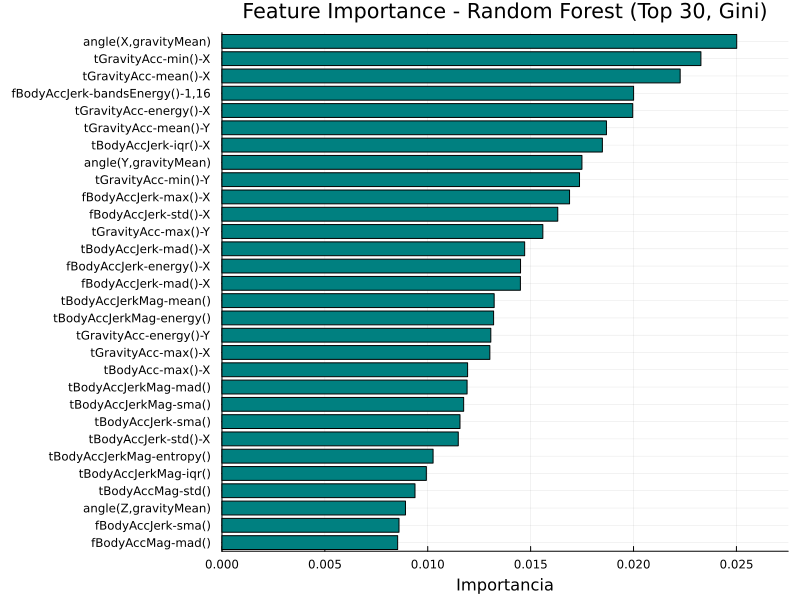

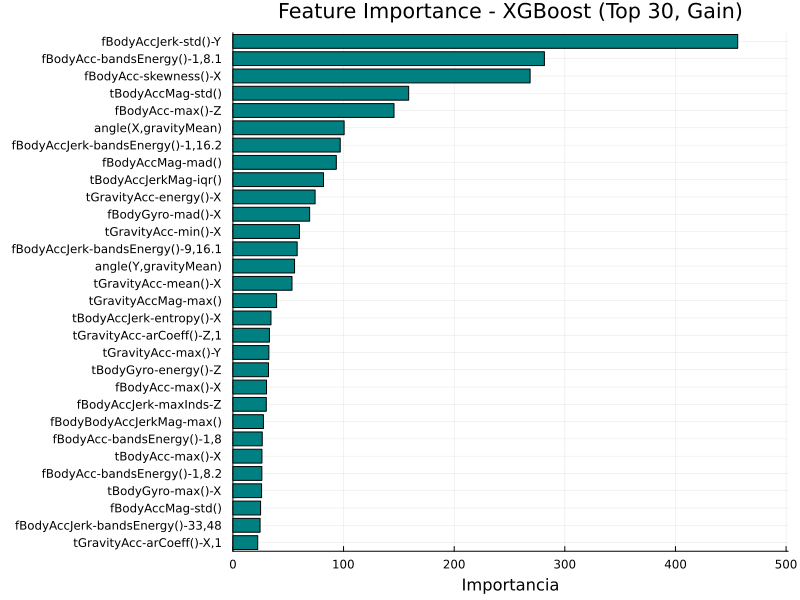

Gráfico guardado en: RF_feature_importance.png
Gráfico guardado en: XGB_feature_importance.png


In [29]:
using Plots

function plot_feature_importance(model, model_name; top_n=30, metric="Gini Gain", save_path=nothing)
    
    fi_raw = sort(collect(feature_importances(model)), by = x -> x[2], rev = true)
    n_display = min(top_n, length(fi_raw))
    fi_vals = reverse([val for (_, val) in fi_raw[1:n_display]])
    feature_names = reverse([string(sym) for (sym, _) in fi_raw[1:n_display]])

    p = bar(
        1:n_display,
        fi_vals,
        orientation = :horizontal,
        label = model_name,
        color = :teal,
        yticks = (1:n_display, feature_names),
        xlabel = "Importancia",
        ylabel = "",
        title = "Feature Importance - $model_name (Top $n_display, $metric)",
        legend = false,
        size = (800, 600),
    )

    xlims!(p, 0, maximum(fi_vals) * 1.1)
    ylims!(p, 0.5, n_display + 0.5)
    
    display(p)

    # Guardar si se especifica path
    if save_path != nothing
       savefig(p, save_path)
       println("Gráfico guardado en: $save_path")
    end
end

plot_feature_importance(machines_ensembles_complex["Random Forest"], "Random Forest", metric="Gini", save_path="RF_feature_importance.png")
plot_feature_importance(machines_ensembles_complex["XGBoost"], "XGBoost", metric="Gain", save_path="XGB_feature_importance.png")



## Visualización

Generando PCA
Generando LDA
Generando ICA
Generando t-SNE
Generando Isomap
Generando LLE


┌ Warning: Found 3 connected components. Largest component is selected.
└ @ ManifoldLearning C:\Users\aniba\.julia\packages\ManifoldLearning\qUlAd\src\utils.jl:95


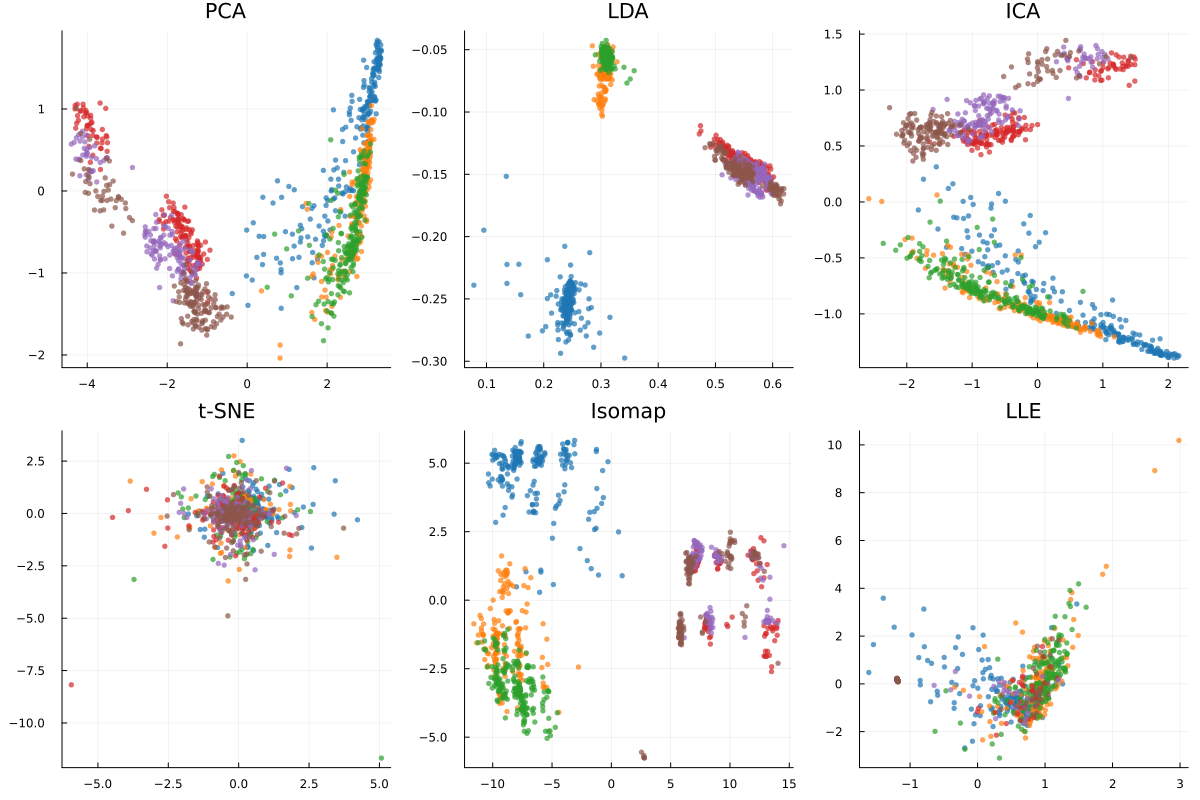

In [71]:
using Plots, StatsBase, Random
import MLJModelInterface

# Normalización MIN-MAX
scaler_m = machine(MinMaxNormalizer(), X_train)
fit!(scaler_m, verbosity=0)

X_train_scaled = MLJ.transform(scaler_m, X_train)
X_test_scaled = MLJ.transform(scaler_m, X_test)

# Ajustes para ManifoldLearning
# Tipos de datos y formato
X_test_mat = MLJ.matrix(X_test_scaled)' 
y_test_plot = y_test

# Para Isomap: Se usa una submuestra del Train para el ajuste, por temas de problemas de memoria 
Random.seed!(SEED)
idx_train_sub = sample(1:nrow(X_train_scaled), 1000, replace=false)
X_train_sub = MLJ.matrix(X_train_scaled)[idx_train_sub, :]' 

# -----------------------------------------------------------------------

# Función para graficar reductores MLJ (PCA, LDA, ICA)
function plot_transformed_data(name::String, reducer, X_f, y_f, X_t, y_t)
    println("Generando $name")
    
    # Se crea la máquina según si es supervisado o no
    if MLJModelInterface.is_supervised(reducer)
        mach_red = machine(reducer, X_f, y_f)
    else
        mach_red = machine(reducer, X_f)
    end

    # Se ajusta el modelo
    fit!(mach_red, verbosity=0)
    X_reduced = MLJ.matrix(MLJ.transform(mach_red, X_t))
    
    # Gráfica en 2D
    return scatter(X_reduced[:, 1], X_reduced[:, 2], group=y_t, 
                   title=name, markersize=3, markerstrokewidth=0, 
                   alpha=0.7, palette=:tab10, legend=:none)
end

# -----------------------------------------------------------------------

# TÉCNICAS MLJ: PCA, LDA e ICA
techniques = [
    ("PCA", PCA_model(maxoutdim=2)),
    ("LDA", LDA_model(outdim=2)),
    ("ICA", ICA_model(outdim=2))
]

# Generar las gráficas
plots_list = [plot_transformed_data(n, r, X_train_scaled, y_train, X_test_scaled, y_test) 
              for (n, r) in techniques]

# -----------------------------------------------------------------------

# t-SNE (Aplicado directamente sobre el Test)
println("Generando t-SNE")
X_tsne = tsne(MLJ.matrix(X_test_scaled), 2, 0, 10, 30.0)
p_tsne = scatter(X_tsne[:,1], X_tsne[:,2], group=y_test, title="t-SNE", 
                 markersize=3, markerstrokewidth=0, alpha=0.7, palette=:tab10, legend=:none)
push!(plots_list, p_tsne)

# Isomap: Se ajusta sobre una submuestra del Train y se aplica sobre el Test
println("Generando Isomap")
iso_fit = ManifoldLearning.fit(Isomap, X_train_sub; k=15, maxoutdim=2)
X_iso_res = ManifoldLearning.predict(iso_fit, X_test_mat)'
n_iso = size(X_iso_res, 1)
p_iso = scatter(X_iso_res[:,1], X_iso_res[:,2], group=y_test[1:n_iso], title="Isomap", 
                markersize=3, markerstrokewidth=0, alpha=0.7, palette=:tab10, legend=:none)
push!(plots_list, p_iso)

# 6. LLE Se ajusta directamente sobre el test
println("Generando LLE")
lle_fit = ManifoldLearning.fit(LLE, X_test_mat; k=50, maxoutdim=2)
X_lle_res = ManifoldLearning.predict(lle_fit)'
n_lle = size(X_lle_res, 1)
p_lle = scatter(X_lle_res[:,1], X_lle_res[:,2], group=y_test[1:n_lle], title="LLE", 
                markersize=3, markerstrokewidth=0, alpha=0.7, palette=:tab10, legend=:none)
push!(plots_list, p_lle)

# -----------------------------------------------------------------------

# Visualización final con las 6 gráficas
visualizacion_dimensiones = plot(plots_list..., layout=(2,3), size=(1200, 800))

savefig(visualizacion_dimensiones, "visualizacion_dimensiones_6.pdf")

visualizacion_dimensiones